In [2]:
import imp
from io import BytesIO
from cv2 import COLOR_BGR2GRAY, VideoCapture, threshold
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image

from scipy import signal
from IPython.display import HTML


from multiprocessing import Pool, pool
from functools import partial


/tmp/ipykernel_36675/2144398346.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
def calibrate_camera():
    objpoints = []
    imgpoints = []

    obj = np.zeros(shape=(6*9, 3), dtype=np.float32)
    obj[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)        

    images = glob.glob("camera_cal/*.jpg")
    for i in images:
        img = cv2.imread(i)
        if(img.shape[0] != 720 or img.shape[1] != 1280):
            img = cv2.resize(img, (1280, 720))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6))

        if(ret):
            imgpoints.append(corners)
            objpoints.append(obj)

    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)

def undistort_camera(input_image, calib_params):
    return cv2.undistort(input_image, calib_params[1], calib_params[2])

In [4]:
def binaryFilterRoadPavement (img):
    HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    #calc the dimionsion of rio, and the posion of it
    width = img.shape[1]
    height = img.shape[0]
    xCenter = np.int(width/2)
    rioWidth = 100
    rioHeight = 200
    xLeft  = xCenter  - np.int(rioWidth/2)
    xRight  = xCenter  + np.int(rioWidth/2)
    yTop =  height - 30
    yBottom = height - rioHeight
    yBottomSmall = yTop - np.int(rioHeight/2)
    xOffset= 50
    xFinish =  width - xOffset

    #get the rio from image by slicing the img
    #the middle
    rioCenter = img[yBottom :yTop, xLeft:xRight ]
    #the left side
    rioLeft  = img[yBottomSmall:yTop, xOffset:(xOffset + rioWidth)]
    #the right side
    rioRight = img [yBottomSmall:yTop, (xFinish- rioWidth) : xFinish]
    #put them beside each other
    rio = np.hstack((rioCenter[0:170],np.vstack((rioLeft,rioRight)[0:170])))##################
    rioHSV = cv2.cvtColor(rio,cv2.COLOR_BGR2HSV)

    #calc histiogrma
    rioHist = cv2.calcHist([rioHSV],[0,1],None, [256,256],[0,256,0,256])


    #normalize the histo
    cv2.normalize(rioHist,rioHist,0,255,cv2.NORM_MINMAX)
    #reflect it into to the img 
    dst = cv2.calcBackProject([rioHSV],[0,1],rioHist,[0,256,0,256],1)##########

    #cracte the filter we go with it throught the image
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    cv2.filter2D(dst, -1, disc, dst)

    #thershold the image
    ret , thersh  = cv2.threshold(dst,10, 250, cv2.THRESH_BINARY_INV)

    return thersh


def compinedThreshold(img, kernal = 3, gradThreshold= (30,100), magThreshold =(70, 100),
                    dirThreshold =(0.8, 0.9), sThreshold = (100, 255),rThreshold = (150, 255),
                    uThreshold = (140,180), threshold = "dayTime-filter-pavement"):


    def binaryThreshold(channel, thresh =(200,255), on = 1):
        binary = np.zeros_like(channel)
        binary[(channel > thresh[0]) & (channel <= thresh[1])] = on

        return binary
        
    if threshold in ["dayTime-bright",  "dayTime-filter-pavement"]:
        rThreshold = (210, 255)

    #cvt to gray
    gray =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #sobel in x dir, and y dir
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= kernal)
    sobely = cv2.Sobel(gray, cv2.CV_64F , 0, 1, ksize=kernal)

    #sobel x grad binary
    absSobelX = np.absolute(sobelx)
    scaledAbsSobelx = np.uint8(255 * (absSobelX/np.max(absSobelX)))
    gradX = binaryThreshold(scaledAbsSobelx,gradThreshold)

    #sobel y grad binary
    absSobelY = np.absolute(sobely)
    scaledAbsSobelY = np.uint8(255 * (absSobelY/np.max(absSobelY)))
    gradY = binaryThreshold(scaledAbsSobelY, gradThreshold)


    #sobel mag grad binary
    gradMag = np.sqrt(sobelx**2 + sobely**2)
    scaledGradMag = np.uint8(255 * (gradMag/ np.max(gradMag)))
    gradMagBinary = binaryThreshold(scaledGradMag, magThreshold)

    #sobel dir binar
    # gradDir = np.arctan2(absSobelY/absSobelY)
    gradDir = np.arctan2(absSobelY,absSobelX)
    scaledGradDir = np.uint8(255 * (gradDir / np.max(gradDir)))
    gradDirBinary =  binaryThreshold(scaledGradDir, dirThreshold)


    #RGB color
    R = img[:,:,2]
    G = img[:,:,1]
    B = img[:,:,0]
    RBinary = binaryThreshold(R,rThreshold)

    #HLS colour 
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = img[:,:,0]
    L = img[:,:,1]
    S = img[:,:,2]
    SBinary = binaryThreshold(S, sThreshold)

    #YUV colour 
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    Y = img[:,:,0]
    U = img[:,:,1]
    V = img[:,:,2]
    UBinary = binaryThreshold(U, uThreshold)


    compined = np.zeros_like(gradDirBinary)

    if threshold == "dayTime-normal":
        compined[ (gradX==1) | (SBinary==1) | (RBinary == 1) ] = 1
    elif threshold == "dayTime-shadow":
        compined[((gradX == 1) & (gradY == 1)) | (RBinary == 1)] = 1
    elif threshold == "dayTime-bright":
        compined[((gradX == 1) & (gradY ==1)) | ((gradMagBinary == 1)& (gradDirBinary == 1)) | (SBinary == 1) | (RBinary == 1)] = 1
    elif threshold == "dayTime-filter-pavement":
        roadBinary = binaryThreshold(binaryFilterRoadPavement(img))
        compined [(((gradX ==1) | (SBinary ==1)) & (roadBinary == 1)) | (RBinary == 1)] = 1
    else:
        compined[((gradX ==1) | (RBinary ==1)) & ((SBinary == 1) | (UBinary == 1) | (RBinary == 1))] = 1

    return compined


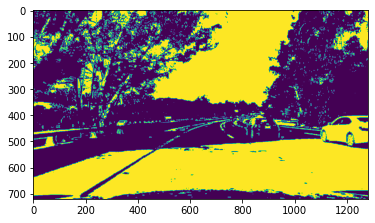

In [5]:
img = plt.imread("Project_data/test_images/test5.jpg")
calib_params = calibrate_camera()
undis = undistort_camera(img,calib_params)
test = compinedThreshold(undis,threshold="dayTime-normal")
plt.imshow(test)

In [6]:
  
def perspective_transforms(src,dst):
    M = cv2.getPerspectiveTransform(src,dst)
    MInv = cv2.getPerspectiveTransform(src,dst)
    return M, MInv

def warp(img, M):
    imgSize = (img.shape[0],img.shape[1])

    warpped = cv2.warpPerspective(img, M,imgSize,flags = cv2.INTER_LINEAR)
    return warpped

def uuWarp(img, MInv):
    imgSize = (img.shape[0],img.shape[1])

    unWarpped = cv2.warpPerspective(img, MInv,imgSize,flasgs = cv2.INTER_LINEAR)
    return unWarpped

def clacWarpPoint(imgHeight, imgWidth, xCenterAdj = 0):

    imgShape  = (imgHeight,imgWidth)
    xCenter = imgShape[1]/2 + xCenterAdj

    xBottom  = 54#fronttt
    yBottom = 450
    xOffset = 120

    src = np.float32(
        [(xOffset,imgShape[0]),
        (xCenter-xBottom,yBottom),
        (xCenter + xBottom, yBottom),
        (imgShape[1]-xOffset, imgShape[0])

        ]
    )

    #with the same order we map 1st point -> 1st point 

    dst = np.float32(
        [(xOffset,imgShape[1]),
        (xOffset,0),
        (imgShape[0]-xOffset, 0),
        (imgShape[0]-xOffset, imgShape[1])
        ]
    )

    return src , dst


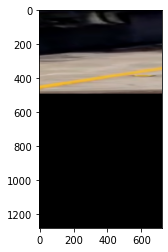

In [7]:
src,dst = clacWarpPoint(img.shape[1], img.shape[0])
M,_ = perspective_transforms(src,dst)
warpped = warp(undis , M)
test = compinedThreshold(warpped,threshold="dayTime-normal")
plt.imshow(warpped)

In [8]:

def binaryImage(img, calib_params , threshold ="dayTime-normal"):

    
    def noiseDetect(warpped) :
        histogram = np.sum(warpped, axis= 1)
        return (histogram>100).any() 

    #############undistort
    undistort = undistort_camera(img, calib_params)

    src, dst = clacWarpPoint(undistort.shape[0],undistort.shape[1])

    M, _ =perspective_transforms(src,dst)

    if threshold == "dayTime-normal":
        # warpped  = warp(undistort,M)
        # compined =compinedThreshold(warpped, threshold=threshold)


        compined =compinedThreshold(undistort, threshold=threshold)
        warpped  = warp(compined,M)
        if noiseDetect(warpped):
            compined = compinedThreshold(undistort, threshold= "dayTime-shadow")
            warpped = warp(compined, M)

            # warpped  = warp(undistort,M)
            # compined =compinedThreshold(warpped, threshold="dayTime-shadow")

    else :
        compined =compinedThreshold(undistort, threshold=threshold)
        warpped  = warp(compined,M)

        # warpped  = warp(undistort,M)
        # compined =compinedThreshold(warpped, threshold=threshold)

    return warpped

113

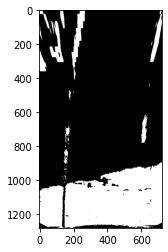

In [9]:
test = binaryImage(img,calib_params,threshold="dayTime-bright")
plt.imshow(test, cmap='gray')
cv2.imshow("lane",np.array(test, dtype = np.uint8 ))
cv2.waitKey(int(1000*30))


In [10]:

def laneHisto(img, heightS=800, heightE = 1250):
    histogram = np.sum(img[int(heightS):int(heightE),:], axis = 0)
    return histogram

def lanePeaks(histo):
    peaks= signal.find_peaks_cwt(histo, np.arange(1,150),min_length=150)
    midpoint = np.int(histo.shape[0]/2)


    #if there more than one peaks happens in shadows
    if len(peaks) > 1:
        peakLeft , *_, PeakRight = peaks

    else :
        #there's only two
        peakLeft = np.argmax(histo[:midpoint])
        peakRight =midpoint + np.argmax(histo[midpoint:])

    return peakLeft, peakRight


class WindowBox (object):
    def __init__(self, binaryimg, xCenter,yTop , width = 100, height = 80, minCount = 50, laneFound = False):
        self.xCenter = xCenter
        self.yTop = yTop
        self.width = width
        self.height = height
        self.minCount = minCount
        self.laneFound = laneFound

        #drived
        self.xLeft = self.xCenter - int(self.width/2)
        self.xRight = self.xCenter + int(self.width/2)
        self.yBottom = self.yTop - self.height

        self.imgWindow = binaryimg[
            self.yBottom:self.yTop,
            self.xLeft: self.xRight
        ]

        #get these non zeros from the slice of the image so 0,0 it's for the window not the total img
        self.nonZeroY = self.imgWindow.nonzero()[0]
        self.nonZeroX = self.imgWindow.nonzero()[1] 
        # self.nonZeroY = np.nonzero(self.imgWindow)[0]
        # self.nonZeroX = np.nonzero(self.imgWindow)[1]

        
    def center(self):
        return (self.xCenter, (self.yTop-self.yBottom)/2)

    def _nonZeroCount(self):
        return len(self.nonZeroX)

    def _isNoise(self):
        return (self._nonZeroCount()>self.imgWindow.shape[0] * self.imgWindow.shape[1] * 0.75)

    def hasLine(self):
        return (self._nonZeroCount() > self.minCount ) ^ self._isNoise() 

    def nextWindow(self, binaryImg):

        if self.hasLine():
            #recenter
            xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))

        else:
            #same
            xCenter = self.xCenter

        #it starts from the one after it 
        yTop = self.yBottom

        return WindowBox(binaryImg,xCenter,yTop, width=self.width,
                        height=self.height, minCount= self.minCount,
                        laneFound=self.laneFound)

    def hasLane(self):
        if not self.laneFound and self.hasLine():
            self.laneFound =True
        return self.laneFound

    def getYTop(self):
        return self.yTop
    def __str__(self):
        return "WindowBox [%.3f, %.3f, %.3f, %.3f]" % (self.xLeft,
                                                       self.yBottom,
                                                       self.xRight,
                                                       self.yTop)


def findLaneWindows(windowBox, binaryImg):
    boxes = []

    #add all windows on the frame for one line

    continueLaneSearch  = True
    contugousBoxNoLineCount = 0

    #we search uless the frame is ended or we go on wrong path where there no lines
    while(continueLaneSearch and windowBox.getYTop() >= 0):
        if windowBox.hasLine():
            boxes.append(windowBox)

        windowBox = windowBox.nextWindow(binaryImg)

        if windowBox.hasLane() :
            if windowBox.hasLine():
                contugousBoxNoLineCount = 0
            else:
                contugousBoxNoLineCount += 1

                if contugousBoxNoLineCount >= 4:
                    continueLaneSearch = False

    return boxes



def calcLeftAndRightlaneWindows (binaryImage, nWindows = 12 , width = 100):

    windowHeight = np.int(binaryImage.shape[0] / nWindows)

    #left, and right lane centers
    windowStartLeft , windowStartRight = lanePeaks(laneHisto(img=binaryImage))

    #the y we start from to detect lines
    windowYTop = binaryImage.shape[0]


    startWindBoxL = WindowBox(binaryImage, windowStartLeft, windowYTop, width=width, height=windowHeight)

    startWindBoxR = WindowBox(binaryImage, windowStartRight, windowYTop, width=width, height=windowHeight)
    

    findLaneWindowsFixedArg = partial(findLaneWindows, binaryImg= binaryImage)

    # paralel function in two threads with different data
    with Pool(2) as p : 
        leftBox, rightBox = p.map(findLaneWindowsFixedArg, [startWindBoxL,startWindBoxR])

    # leftBox = findLaneWindows(startWindBoxL, binaryImg=binaryImage)
    # rightBox = findLaneWindows(startWindBoxR, binaryImg=binaryImage)

    return (leftBox, rightBox)

def calcFitFromBoxes(boxes):
    if len(boxes) > 0:
        #flatten put the vales besides each othe in 1d array

        #the nonzero represnt the point in the window img not the total image so we sum (0,0) on it left
        x = np.concatenate([box.nonZeroX + box.xLeft for box in boxes])
        y = np.concatenate([box.nonZeroY + box.yBottom for box in boxes])

        return np.polyfit(y,x,2) #a x**2 + b * x + c
    else:
        return None



def clacFitX(fitY, lineFit):
    fitLineX = lineFit[0] * fitY**2 + lineFit[1] * fitY + lineFit[2]
    return fitLineX


def calcLeftRightFromPoly(binimg, leftFit, rightFit, margin):
    nonzero = binimg.nonzero()
    nonzeroY = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    def windowLane(poly):
        return (
            (nonzerox > (poly[0]* (nonzeroY**2) + poly[1]*nonzeroY + poly[2] - margin))
            & (nonzerox > (poly[0]* (nonzeroY**2) + poly[1]*nonzeroY + poly[2] + margin))

        ) 

    def windowPolyFit (lane):
        x = nonzerox[lane]
        y = nonzeroY[lane]

        return np.polyfit(y,x,2)

    newLeftFit = leftFit
    if leftFit is not None:
        newLeftFit = windowPolyFit(windowLane(leftFit))

    newRightFit = rightFit

    print(rightFit)
    if rightFit is not None:
        newRightFit = windowPolyFit(windowLane(rightFit))

    return (newLeftFit,newRightFit)


In [19]:
def lines(img, withMargin = 1):
    topDowmImage =binaryImage(  img,calib_params=calib_params)
    height = topDowmImage.shape[0]
    histogram = laneHisto(topDowmImage)
    peakLeft , peakRight = lanePeaks(histogram)
    boxLeft, boxRight = calcLeftAndRightlaneWindows(topDowmImage,width=150)
    leftFit = calcFitFromBoxes(boxLeft)
    rightFit = calcFitFromBoxes(boxRight)

    fitY = np.linspace(0, height-1, height)
    if leftFit is not None: 
        fit_leftx = clacFitX(fitY, leftFit)
    if rightFit is not None: 
        fit_rightx = clacFitX(fitY, rightFit)

    
    margin=100
    new_left_fit, new_right_fit = calcLeftRightFromPoly(topDowmImage, leftFit, rightFit, margin)
    
    if new_left_fit is not None:
        new_leftx = clacFitX(fitY, new_left_fit)
    if new_right_fit is not None:    
        new_rightx = clacFitX(fitY, new_right_fit)
    # f, ((ax3,ax4), (ax1, ax2)) = plt.subplots(2, 2, figsize=(20,10))
    # ax1.set_title("warped box seek")
    # ax1.imshow(topDowmImage,cmap='gray')
    # ax1.plot(height-histogram)
    # ax1.plot((height,peakLeft), (height,height-histogram[peakLeft]), 'rx')
    # ax1.plot((height,peakRight), (height,height-histogram[peakRight]), 'rx')
    # # for b in boxLeft + boxRight:
    # #     ax1.add_patch(patches.Rectangle((b.x_left, b.y_bottom),b.width,b.height,facecolor="none",edgecolor="green"))
    # if new_leftx is not None:
    #     ax1.plot(fit_leftx , fitY, color='yellow')
    # if new_rightx is not None:
    #     ax1.plot(fit_rightx, fitY, color='yellow')
    # ax1.set_xlim(0, 720)
    # ax1.set_ylim(1280, 0)

    if withMargin != 1:
        return (fit_leftx, fit_rightx)
    else:
         return (new_leftx ,new_rightx) 
    # return clacFitX(fitY, leftFit), clacFitX(fitY, rightFit)

def drawLines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (0,0,255))
            

In [109]:

def drawLaneWarp(img):
    height = img.shape[0]
    leftX, ritghX = lines(img, withMargin = 0)
    topDowmImage = binaryImage(img,calib_params=calib_params)

    heightTD = topDowmImage.shape[0]
    fitY = np.linspace(0, heightTD-1, heightTD)


    black = np.zeros_like(topDowmImage)

    pts_left = np.array([np.transpose(np.vstack([leftX,fitY]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([ritghX,fitY ])))])
    pts = np.hstack((pts_left, pts_right))
   

    # cv2.fillPoly(black, np.int_([pts]),(255,255,255))

    # histogram = laneHisto(topDowmImage)
    # hist_pts=[[i, height-histogram[i]] for i in range(0,topDowmImage.shape[1] -1)]

    # cv2.polylines(topDowmImage,np.int_([hist_pts]), False, (255,255,255))

    cv2.polylines(black,np.int_([pts_left]), False, (255,255,255))
    cv2.polylines(black,np.int_([pts_right]), False, (255,255,255))

    # result = topDowmImage | black


    result = cv2.addWeighted(topDowmImage, .7,black, 0.2, 0)
    plt.imshow(result,cmap="gray")
    return result
   



/tmp/ipykernel_36675/4095638702.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histo.shape[0]/2)
/tmp/ipykernel_36675/4095638702.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

[ 1.23020039e-04 -2.30777806e-01  7.22694848e+02]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

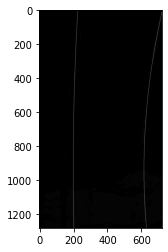

In [102]:
drawLaneWarp(undis)

/tmp/ipykernel_36675/4095638702.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histo.shape[0]/2)
/tmp/ipykernel_36675/4095638702.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

[-1.15628528e-03  1.21064937e+00  1.91818702e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[-3.40888415e-05  1.31578426e-01  4.27535426e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[ 1.57717339e-04 -3.32101820e-01  6.29901444e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[ 6.73348094e-05 -1.57539086e-01  5.53179039e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[ 1.27777819e-04 -2.56425451e-01  5.89688745e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[-1.21712182e-03  1.46344150e+00  4.90778623e+01]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[ 5.12102047e-05 -2.15564719e-01  5.88151725e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[ 8.78799421e-05 -2.70580721e-01  6.01986962e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[ 3.75476124e-05 -1.76378059e-01  5.63572902e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[ 6.38959216e-05 -2.25381976e-01  5.86579048e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[ 6.84186969e-05 -2.26192799e-01  5.83060961e+02]
......................................................................


/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xCenter  = np.int(np.mean(self.nonZeroX + self.xLeft))
/tmp/ipykernel_36675/4095638702.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

[ 7.58365817e-05 -2.38953520e-01  5.84570027e+02]
......................................................................


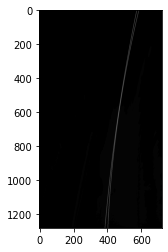

In [110]:
def main():
    video = cv2.VideoCapture("Project_data/challenge_video.mp4")
    calib_params = calibrate_camera()
    
    while(video.isOpened()):
        ret, frame = video.read()
        if(ret):

            # undis = undistort_camera(frame,calib_params)
            # src,dst = clacWarpPoint(undis.shape[1], undis.shape[0])
            # M,_ = perspective_transforms(src,dst)
            # test = binaryImage(img,calib_params,threshold="dayTime-normal")
            test = drawLaneWarp(frame)
            # print(ret)
            print("......................................................................")
            cv2.imshow("lane",test)
            key = cv2.waitKey(int(1000/30))
            if key == ord('q'):
                break
        else:
            break

    video.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()